# # **Clustering**

- Ref (Obtenção de Dados e Embeddings): https://cookbook.openai.com/examples/get_embeddings_from_dataset
- Ref (Modelagem de Clusters): https://cookbook.openai.com/examples/clustering

Nesta etapa vamos agrupar as reclamações por seus embeddings, que são representações vetoriais de alta dimensão que capturam o significado semântico das palavras. Para isso, vamos utilizar o algoritmo KMeans, que é um algoritmo de aprendizado não supervisionado que agrupa os dados em clusters.

Depois, para cada grupo formado, vamos identificar quais categorias de produtos/serviços estes grupos de clientes estariam mais propensos a adquirir.

# # **Importando Pickle da Etapa Anterior**

In [36]:
import pandas as pd

df = pd.read_pickle('./pickle/df_sentiment.pkl')

df.shape

(4887, 133)

In [37]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval

matrix = np.vstack(df["Complaint embedding"].values)

matrix.shape

(4887, 1536)

In [42]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init='auto')
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

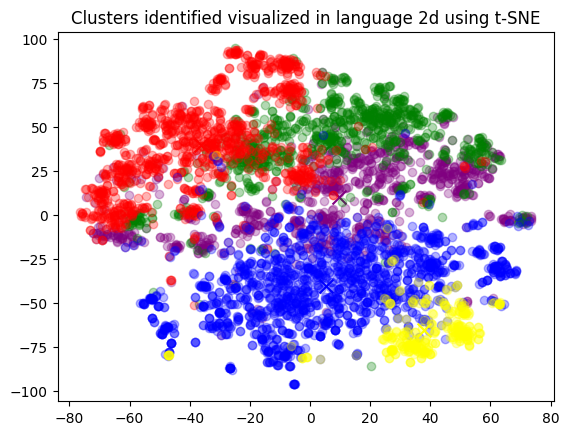

In [43]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [40]:
from openai import OpenAI
import os

client = OpenAI(  
    api_key='sk-',
    organization='org-',
    project='',
    max_retries=5
    )

# Reading a review which belong to each group.
rev_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]["Consumer complaint narrative"]
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'These complaints against financial institucions are part of the same cluster.\n\nDetermine which financial product/service categories these clients are more likely to purchase.\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)




Cluster 0 Theme: Credit Card Services & Debt Collection
Cluster 1 Theme: Credit/Debit Card Services and Fraud Protection
Cluster 2 Theme: Credit Reporting and Identity Protection Services
Cluster 3 Theme: Banking Services (including Checking and Savings Accounts, Credit Cards, ATM Services) and Fraud Protection Services.
Cluster 4 Theme: Credit Reporting and Privacy Rights Violations
